In [1]:
from database import get_thread_sample, get_comments_sample, bulk_update_comments

/opt/ipnb3/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import pandas as pd

In [3]:
def from_cursor_to_df(cursor):
    return pd.DataFrame.from_dict(list(cursor))

In [4]:
comments_field_list = ['body', 'subreddit', 'score', 'is_esl_related', 'created_utc', 'flair_sentiment']

In [5]:
#get_xxx_sample returns a mongo cursor with results from the specified aggregation
#
#limit -> use limit to define the number of results (random sample, default = 1000)
#esl_related -> true or false to get only results related or not to the esl. None to get both (default = None)
#include -> list of included fields. None -> return all the fields. default = ['body','_id']

df_comments = from_cursor_to_df(get_comments_sample(limit=20000, esl_related = True, include = comments_field_list))

In [6]:
df_comments['date_created'] = pd.to_datetime(df_comments['created_utc'], unit='s')
df_comments.drop(columns=['created_utc'], inplace=True)

df_comments['is_esl_related'].fillna(False, inplace=True)


In [7]:
len(df_comments)

20000

In [8]:
df = df_comments

In [9]:
df

,_id,body,score,subreddit,is_esl_related,flair_sentiment,date_created
0,60860c40c17c650b4e0f07f3,"I know this is great from us, but I reckon rum...",1,soccer,True,NEGATIVE,2021-04-18 17:59:22
1,60863ef9c17c650b4e10e832,So England gets bounced in the group stage. I'...,1,soccer,True,POSITIVE,2021-04-19 13:41:18
2,60861b86c17c650b4e0f6f2d,domestic leagues wont let this happen thou,2,soccer,True,NEGATIVE,2021-04-18 23:47:34
3,608662fdc17c650b4e1386ac,Thry should just move the clubs to America ins...,1,soccer,True,NEGATIVE,2021-04-20 16:12:25
4,60862b34c17c650b4e101600,so no changes then?,1,coys,True,NEGATIVE,2021-04-19 12:31:49
...,...,...,...,...,...,...,...
19995,60867db1c17c650b4e15623d,I’m 33 years old and I’m FSG out. You’re naive...,4,LiverpoolFC,True,NEGATIVE,2021-04-21 09:19:52
19996,608692bec17c650b4e16b6bf,Policy wise and in terms of support from young...,1,soccer,True,NEGATIVE,2021-04-23 08:54:03
19997,608631c2c17c650b4e104f33,Solidarity payments are those given to leagues...,1,soccer,True,NEGATIVE,2021-04-19 07:57:08
19998,60866659c17c650b4e13adcc,thats game over for the ESL,1,soccer,True,POSITIVE,2021-04-20 17:52:33


In [10]:
df.body=df.body.astype(str)

In [11]:
df.dtypes

_id                        object
body                       object
score                       int64
subreddit                  object
is_esl_related               bool
flair_sentiment            object
date_created       datetime64[ns]
dtype: object

In [12]:
import nltk
nltk.download('stopwords')

import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_text_1(text):
    # Lowercase
    text = text.lower()
    # Remove email addresses
    text = re.sub('\S*\@\S*', '', text)    
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Remove numbers
    text = re.sub('\d', '', text)    
    # Remove quotes
#    text = re.sub('[‘’“”…]', '', text)
    # Remove new line \n 
    text = re.sub('\n', ' ', text)
    # Remove stop_word
    stop_words = stopwords.words('english')
    words = word_tokenize(text)
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

[nltk_data] Downloading package stopwords to /home/vmuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Let's take a look at the updated text
df_clean = pd.DataFrame(df.body.apply(clean_text_1))

In [14]:
df_clean

,body
0,know great us reckon rumme biding time wayyy ...
1,england gets bounced group stage im sure go w...
2,domestic leagues wont let happen thou
3,thry move clubs america instead compete world...
4,changes
...,...
19995,years old fsg naive think apology genuine own...
19996,policy wise terms support young people id say...
19997,solidarity payments given leagues dont partic...
19998,thats game esl


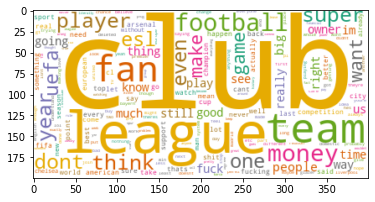

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline  
from wordcloud import WordCloud

alltext=''
for index,row in df_clean.iterrows():
    alltext=alltext+row.body

wc = WordCloud(collocations=False, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

wc.generate(alltext)
plt.imshow(wc, interpolation="bilinear")

plt.show()

In [16]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

def lemmatize(text):
    wnl = WordNetLemmatizer()
    lemma=[]
    for i in word_tokenize(text):
        if len(i) > 3:
            lemma.append(wnl.lemmatize(i))    
    return ' '.join(lemma)


def lemmatize_tag(text):
    wnl = WordNetLemmatizer()
    lemma=[]
    for i,j in pos_tag(word_tokenize(text)) :
        p=j[0].lower()
        if p in ['j','n','v']:
            if p == 'j':
                p = 'a'
            lemma.append(wnl.lemmatize(i,p))
        else :
            lemma.append(wnl.lemmatize(i))    
    return ' '.join(lemma)



In [17]:
data_clean = pd.DataFrame(df_clean.body.apply(lemmatize))

In [18]:
data_clean

,body
0,know great reckon rumme biding time wayyy effi...
1,england get bounced group stage sure well engl...
2,domestic league wont happen thou
3,thry move club america instead compete world s...
4,change
...,...
19995,year naive think apology genuine owner learn d...
19996,policy wise term support young people youre ri...
19997,solidarity payment given league dont participa...
19998,thats game


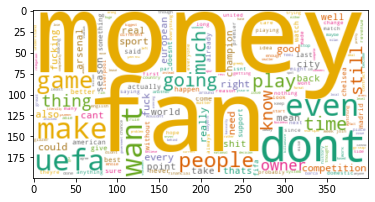

In [19]:
stop_words = stopwords.words('english')
stop_words2=[]

for w in stop_words:
    stop_words2.append(w)

stop_words2.extend(['league','super', 'club', 'team', 'would', 'like', 'football', 'player', 'year', 'think'])
#stop_words2.extend(['league','super', 'would', 'football', 'year', 'think'])
alltext=''
for index,row in data_clean.iterrows():
    alltext=alltext+row.body

wc = WordCloud(collocations=False,stopwords=stop_words2, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

wc.generate(alltext)
plt.imshow(wc, interpolation="bilinear")

plt.show()



In [20]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english',min_df=2)#, max_df=.9)
data_cv = cv.fit_transform(df_clean.body)
data = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data.index = data_clean.index
data

,aa,aarons,abandon,abandoned,abc,aber,abhorrent,abide,abilities,ability,...,zidanes,zlatan,zone,zones,zoom,zurich,zvezda,özil,ødegaard,čeferin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
from gensim import matutils, models
import scipy.sparse

In [22]:
tdm = data.transpose()
tdm.head()

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
aa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aarons,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoned,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [24]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [30]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10)
lda.print_topics()

[(0,
  '0.035*"teams" + 0.017*"league" + 0.015*"football" + 0.015*"clubs" + 0.013*"esl" + 0.011*"team" + 0.011*"year" + 0.011*"money" + 0.010*"play" + 0.009*"big"'),
 (1,
  '0.024*"like" + 0.019*"city" + 0.018*"chelsea" + 0.013*"united" + 0.011*"madrid" + 0.010*"real" + 0.010*"clubs" + 0.010*"man" + 0.009*"liverpool" + 0.009*"vs"'),
 (2,
  '0.036*"deleted" + 0.019*"buy" + 0.011*"dreams" + 0.010*"lmao" + 0.009*"man" + 0.009*"time" + 0.009*"madrid" + 0.009*"real" + 0.008*"game" + 0.007*"shit"'),
 (3,
  '0.034*"fans" + 0.031*"club" + 0.019*"think" + 0.017*"football" + 0.016*"dont" + 0.014*"im" + 0.014*"support" + 0.011*"fan" + 0.011*"like" + 0.010*"love"'),
 (4,
  '0.034*"clubs" + 0.028*"league" + 0.021*"uefa" + 0.012*"fifa" + 0.012*"money" + 0.011*"players" + 0.011*"dont" + 0.010*"super" + 0.010*"think" + 0.009*"cup"'),
 (5,
  '0.013*"club" + 0.010*"players" + 0.009*"thought" + 0.008*"like" + 0.008*"fans" + 0.007*"really" + 0.007*"stadium" + 0.006*"true" + 0.006*"new" + 0.006*"game"'),
 

In [32]:
import pickle

In [33]:
save_lda = open('lda.pickle', 'wb')

In [34]:
pickle.dump(lda, save_lda)

In [35]:
save_lda.close()

## Identify Topics in Each Document

In [27]:
corpus_transformed = lda[corpus]

In [28]:
list(corpus_transformed)

[[(0, 0.01684844),
  (1, 0.016852856),
  (2, 0.016848296),
  (3, 0.016845472),
  (4, 0.016845237),
  (5, 0.84836715),
  (6, 0.016850766),
  (7, 0.016845316),
  (8, 0.01684328),
  (9, 0.016853137)],
 [(0, 0.010011614),
  (1, 0.01001162),
  (2, 0.45855445),
  (3, 0.010012451),
  (4, 0.010010959),
  (5, 0.010011902),
  (6, 0.01001147),
  (7, 0.010012538),
  (8, 0.010013403),
  (9, 0.46134958)],
 [(0, 0.014299856),
  (1, 0.014297982),
  (2, 0.014300638),
  (3, 0.014298406),
  (4, 0.0142988395),
  (5, 0.5538214),
  (6, 0.33178875),
  (7, 0.014297321),
  (8, 0.014297441),
  (9, 0.014299388)],
 [(0, 0.010004905),
  (1, 0.01000159),
  (2, 0.010002689),
  (3, 0.01000355),
  (4, 0.010001418),
  (5, 0.90997666),
  (6, 0.0100026755),
  (7, 0.010001815),
  (8, 0.01000285),
  (9, 0.010001901)],
 [(0, 0.050007213),
  (1, 0.050005436),
  (2, 0.050019547),
  (3, 0.54988295),
  (4, 0.050005436),
  (5, 0.0500145),
  (6, 0.050006524),
  (7, 0.05001217),
  (8, 0.050021555),
  (9, 0.050024677)],
 [(8, 0.947

In [29]:
topic_prediction=[]
for j in list(corpus_transformed):
    main_topic=j[0][0]
    weigth=j[0][1]
    for t,w in j:
        if w > weigth :
            main_topic=t
            weigth=w
    topic_prediction.append(main_topic)

In [31]:
topic_prediction

[5,
 9,
 5,
 5,
 3,
 8,
 4,
 4,
 4,
 5,
 8,
 1,
 8,
 8,
 7,
 5,
 5,
 7,
 4,
 0,
 2,
 3,
 2,
 1,
 1,
 8,
 0,
 6,
 6,
 0,
 7,
 1,
 7,
 5,
 4,
 5,
 0,
 8,
 3,
 0,
 7,
 6,
 4,
 6,
 6,
 1,
 0,
 0,
 5,
 3,
 4,
 7,
 8,
 2,
 6,
 8,
 1,
 6,
 3,
 1,
 0,
 3,
 4,
 9,
 0,
 4,
 4,
 7,
 2,
 1,
 6,
 6,
 6,
 8,
 2,
 7,
 2,
 7,
 8,
 5,
 6,
 2,
 1,
 0,
 9,
 0,
 0,
 3,
 4,
 2,
 4,
 1,
 8,
 5,
 5,
 2,
 0,
 9,
 2,
 9,
 4,
 1,
 0,
 8,
 2,
 6,
 5,
 3,
 7,
 3,
 9,
 5,
 5,
 5,
 0,
 2,
 8,
 1,
 5,
 0,
 3,
 4,
 4,
 1,
 8,
 8,
 2,
 2,
 5,
 1,
 7,
 0,
 8,
 9,
 1,
 2,
 6,
 5,
 7,
 3,
 8,
 8,
 6,
 5,
 5,
 1,
 8,
 3,
 5,
 6,
 2,
 6,
 9,
 3,
 2,
 1,
 9,
 3,
 9,
 6,
 7,
 6,
 8,
 1,
 2,
 9,
 0,
 1,
 5,
 4,
 1,
 2,
 4,
 2,
 9,
 0,
 2,
 3,
 6,
 0,
 4,
 5,
 2,
 6,
 8,
 5,
 0,
 5,
 2,
 5,
 9,
 5,
 5,
 0,
 1,
 5,
 5,
 8,
 2,
 2,
 0,
 0,
 7,
 6,
 6,
 4,
 5,
 6,
 7,
 1,
 1,
 1,
 9,
 8,
 9,
 1,
 2,
 2,
 9,
 8,
 0,
 5,
 1,
 7,
 9,
 1,
 9,
 3,
 1,
 8,
 1,
 4,
 1,
 5,
 5,
 5,
 8,
 6,
 3,
 2,
 4,
 0,
 0,
 5,
 4,
 3,
 1,
 9,
 5,
 0,
